In [1]:
import anndata as ad
import episcanpy.api as epi
import numpy as np
import episcanpy
print(episcanpy.__version__)
import matplotlib.pyplot as plt
import scanpy as sc
import time

# key parameters
nb_of_features = 100000
nb_pcs = 50
target_sum=None
min_cells =10
input_file = 'ATAC_mtx.h5ad'

# specify the directory where data are stored
DATADIR = ''

# specify the directory where data and metadata are stored
METADATADIR = '../../input/'

0.1.7+20.g60484de



In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.



# Load the raw count matrix + annotations/metadata

In [2]:
start = time.time()

In [3]:
# load the data, already as an adata object
adata =ad.read(DATADIR+input_file)
adata

# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')


In [4]:
# save name of original cell name (bam file)
adata.obs['bam_file'] = adata.obs_names.tolist()

# format cell_names
barcodes = []
tissue = []
tmp_cell_names = []
for cell_names in adata.obs_names.tolist():
    tmp_cell_names.append("-".join(cell_names.split('/')[-1].split('.')[:2]))

    
# add annotations
adata.obs['barcodes'] = [name.split('-')[1] for name in tmp_cell_names]
adata.obs['tissue'] = [name.split('-')[0] for name in tmp_cell_names]
adata.obs['long_cell_names'] = tmp_cell_names
# rename the cells to only keep the cell barcode
adata.obs_names = [name.split('-')[1] for name in tmp_cell_names]

# load metadata
epi.pp.load_metadata(adata,
                     metadata_file='metadata.tsv',
                     path=METADATADIR,
                     separator='\t')

adata.obs['label'] = [n.rstrip('\n') for n in adata.obs['label\n']]
del adata.obs['label\n']

        Or use epi.pp.density_features.
    


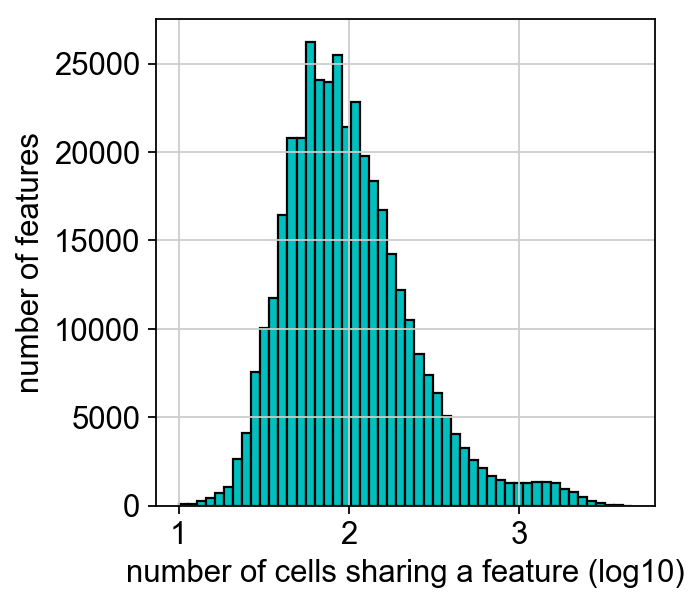

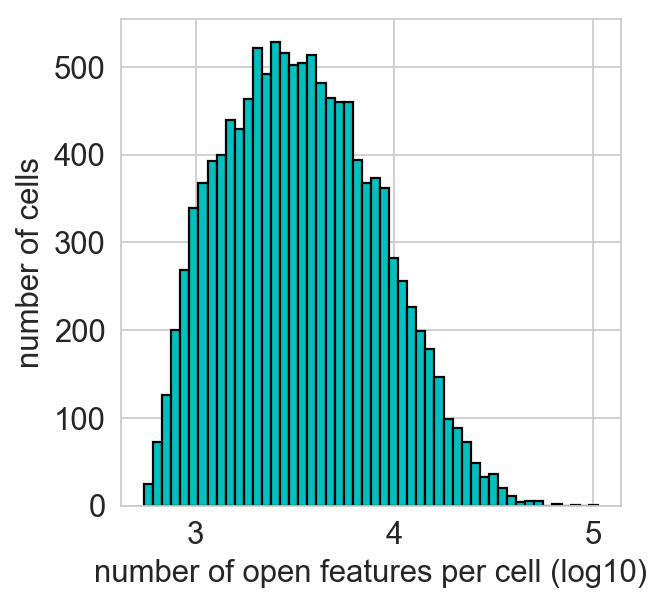

In [5]:
# Quality controls and Preliminary data processing
### remove empty cells and empty features
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=min_cells)

epi.pp.commonness_features(adata, binary=True, log=True)
epi.pp.coverage_cells(adata, binary=True, log=True)


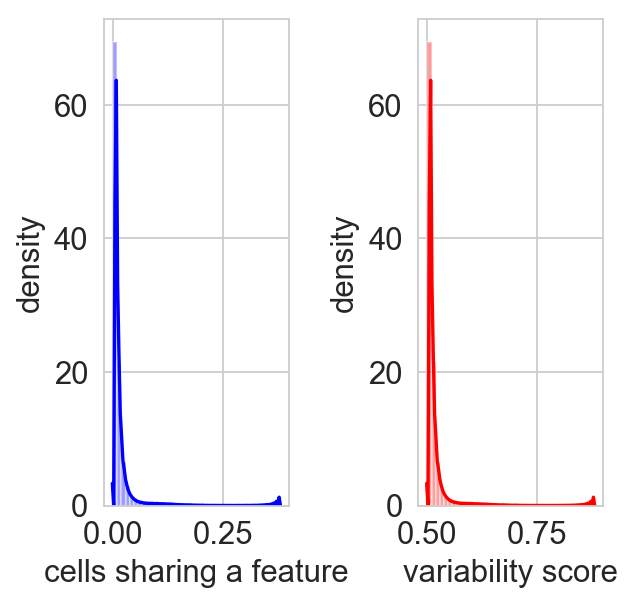

        Or use epi.pp.density_features.
    
Trying to set attribute `.var` of view, making a copy.


View of AnnData object with n_obs × n_vars = 12178 × 100013 
    obs: 'bam_file', 'barcodes', 'tissue', 'long_cell_names', '', 'label', 'nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'omic'


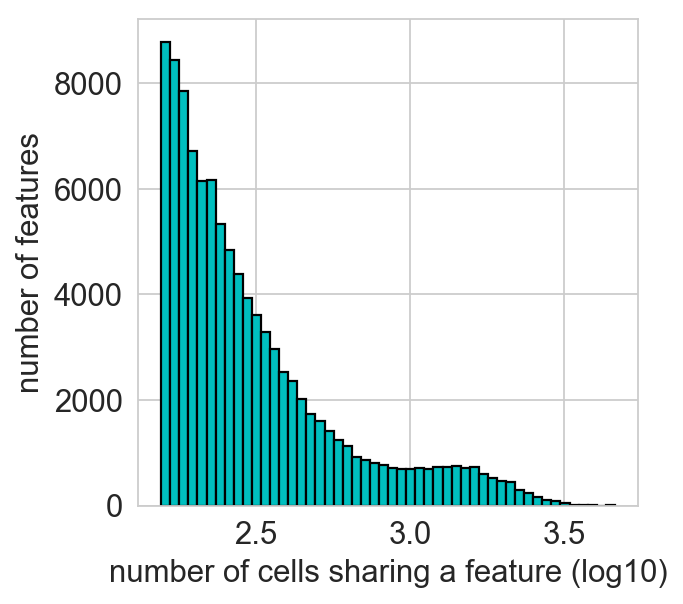

        Or use epi.pp.density_features.
    


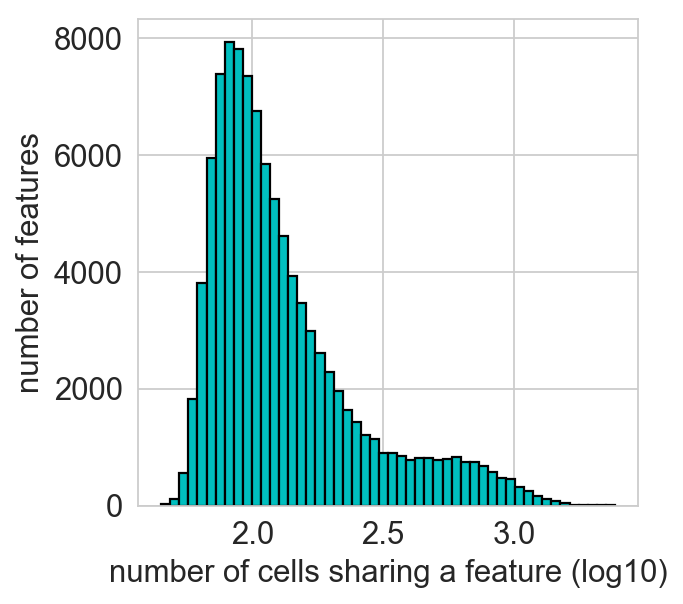

In [6]:
adatareduced = epi.pp.select_var_feature(adata, nb_features=nb_of_features, copy=True)
print(adatareduced)

epi.pp.commonness_features(adatareduced, binary=True, log=True)

epi.pp.normalize_total(adatareduced, target_sum=target_sum, exclude_highly_expressed=False,
 max_fraction=0.05, key_added=None, layers=None, layer_norm=None, inplace=True)
sc.pp.log1p(adatareduced)

epi.pp.commonness_features(adatareduced, binary=True, log=True)

In [7]:
adatareduced

AnnData object with n_obs × n_vars = 12178 × 100013 
    obs: 'bam_file', 'barcodes', 'tissue', 'long_cell_names', '', 'label', 'nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'omic'

# adatareduced

In [8]:
# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')


... storing 'tissue' as categorical
... storing 'label' as categorical


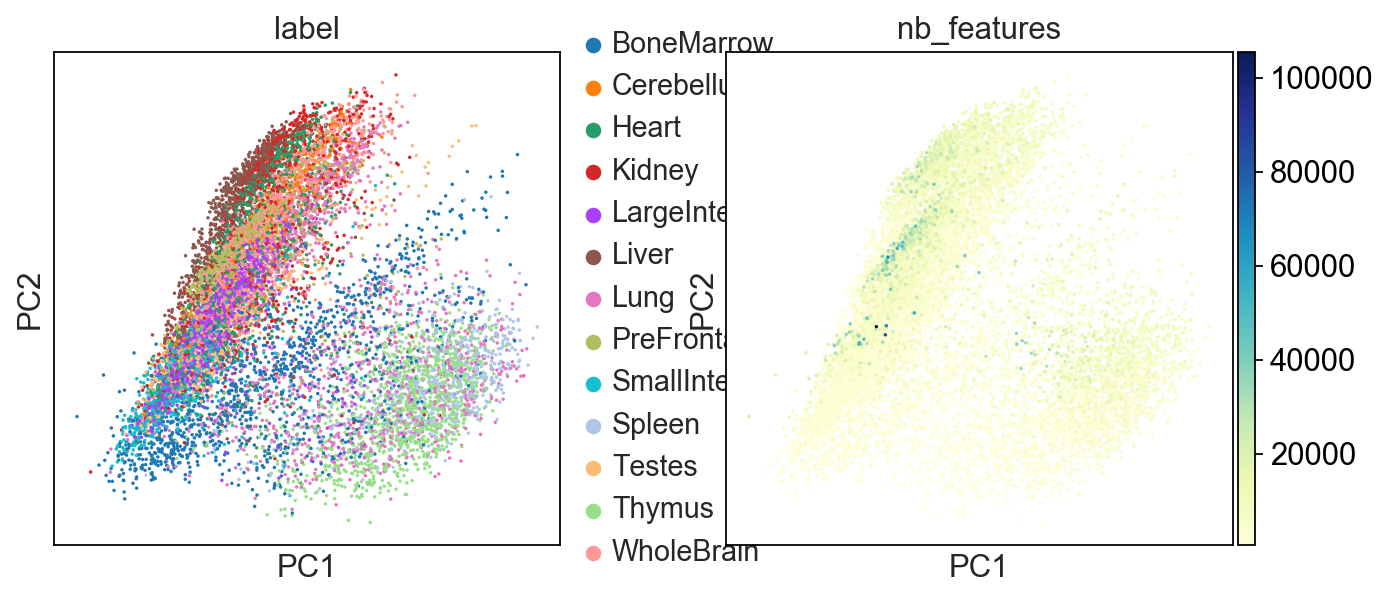

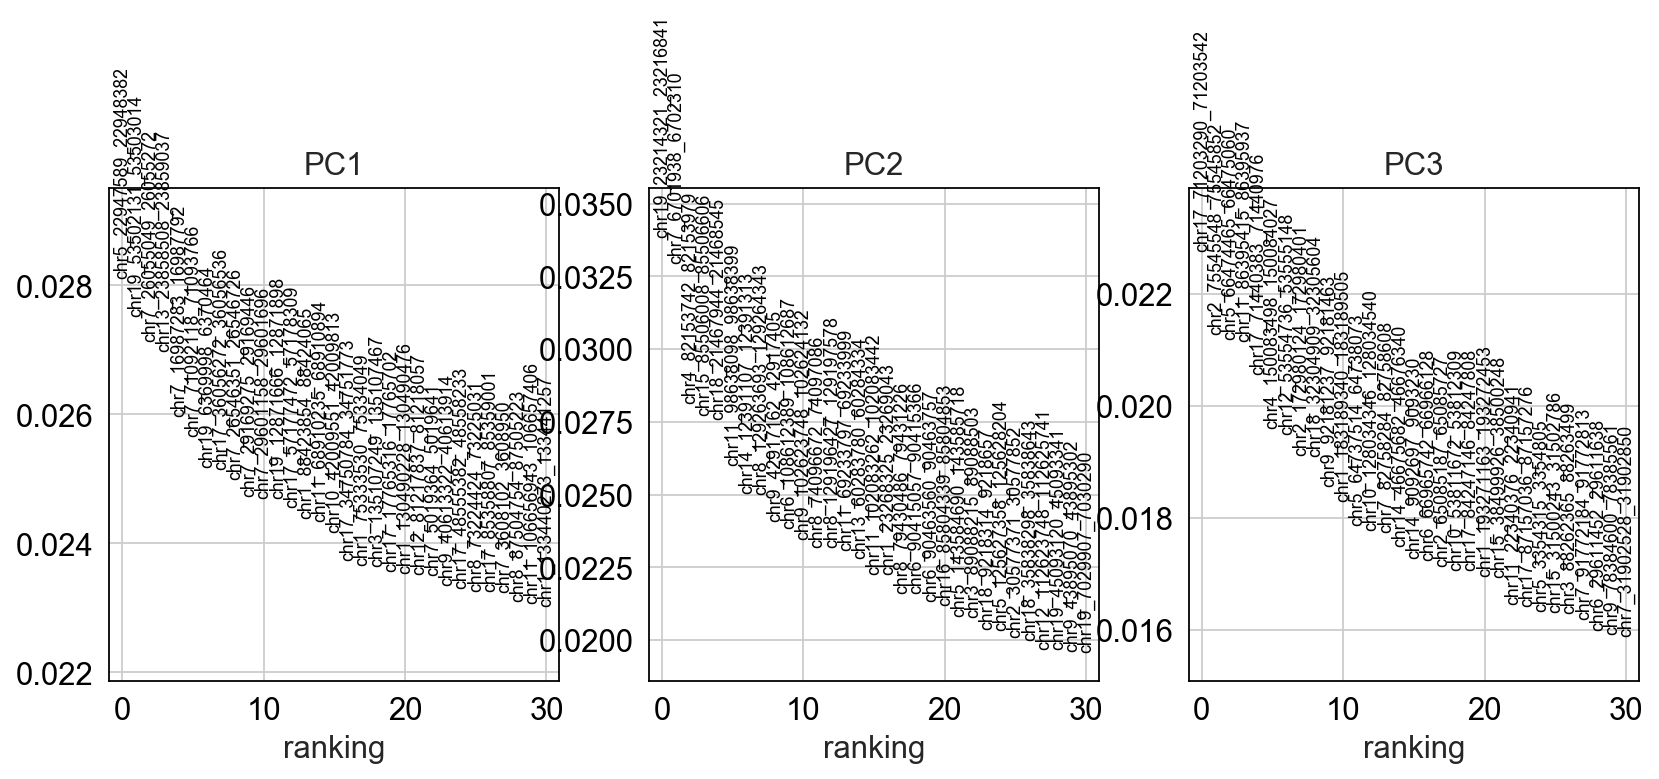

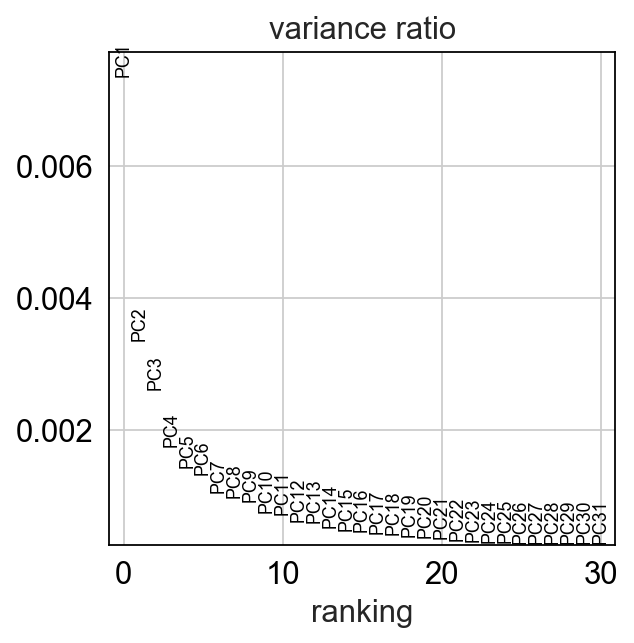

In [9]:
epi.pp.pca(adatareduced, n_comps=nb_pcs, svd_solver='arpack')
sc.pl.pca_overview(adatareduced, color=['label', 'nb_features'])

In [13]:
nb_pcs = 100
epi.pp.pca(adatareduced, n_comps=nb_pcs, svd_solver='arpack')
epi.pp.neighbors(adatareduced, n_neighbors=15, n_pcs=nb_pcs)
epi.tl.umap(adatareduced)
epi.tl.tsne(adatareduced)
epi.tl.louvain(adatareduced)

The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^



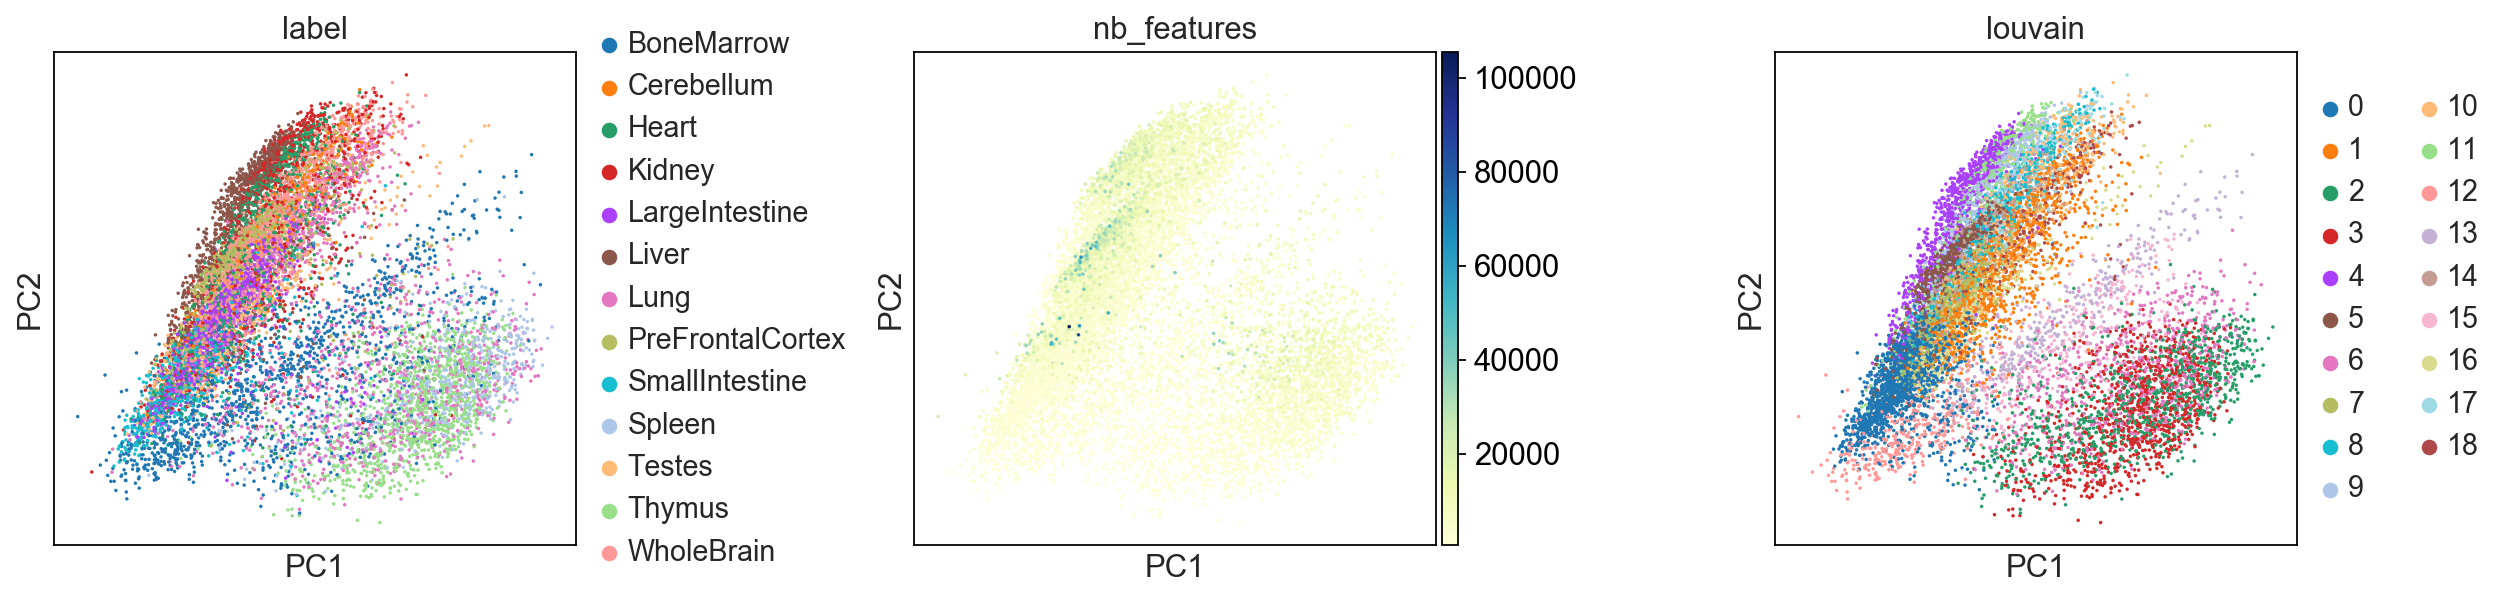

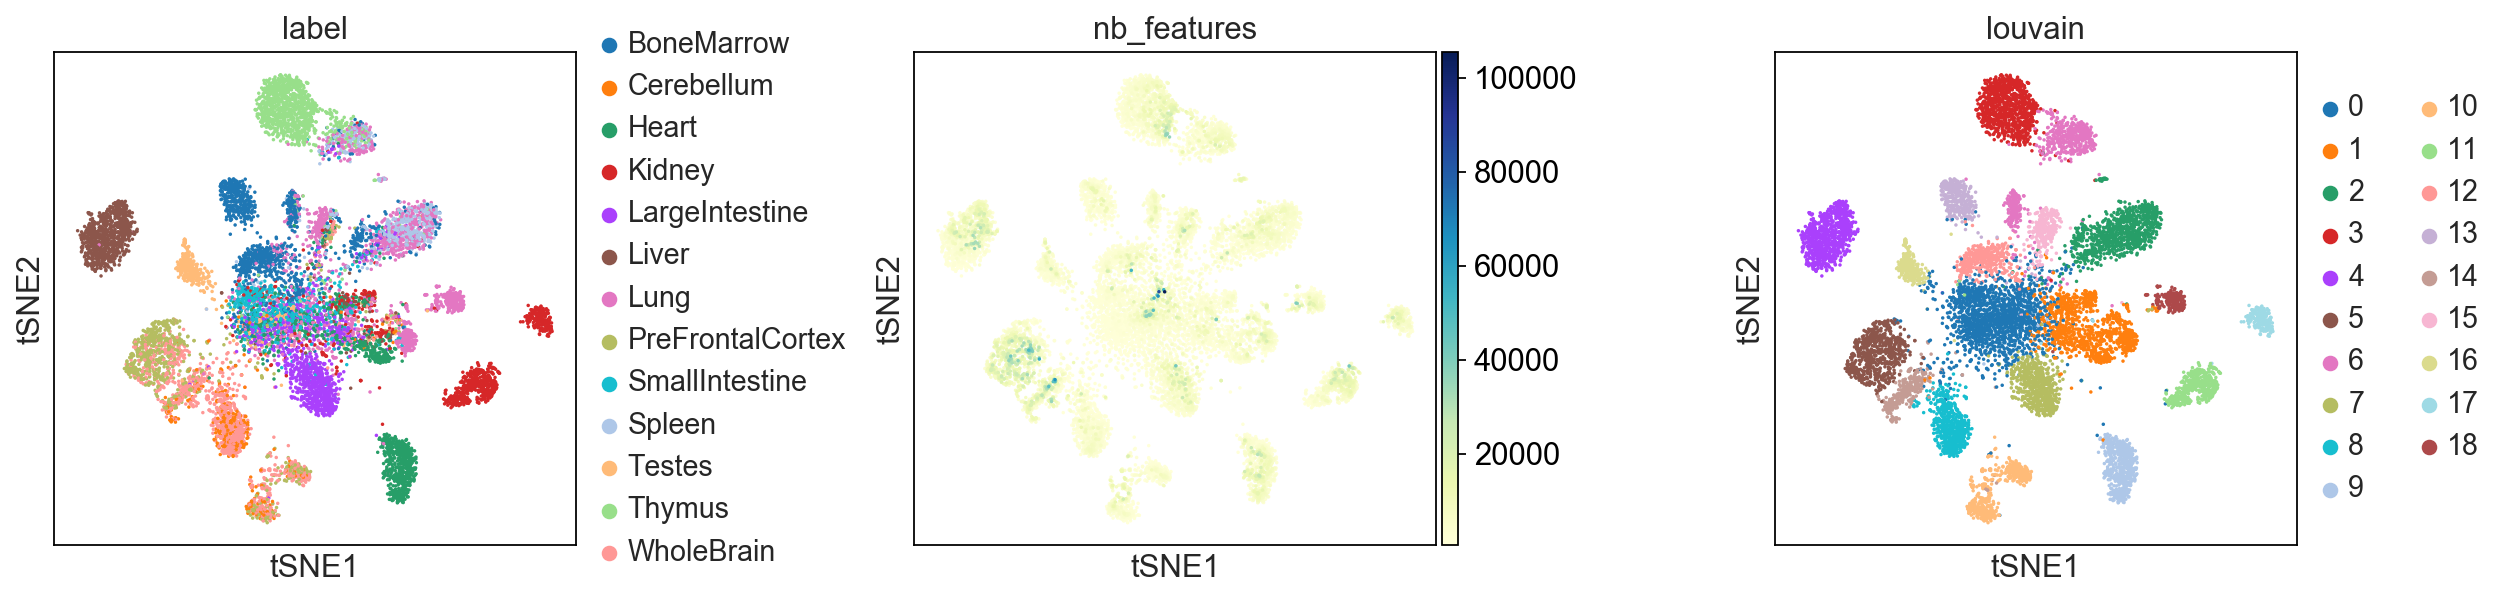

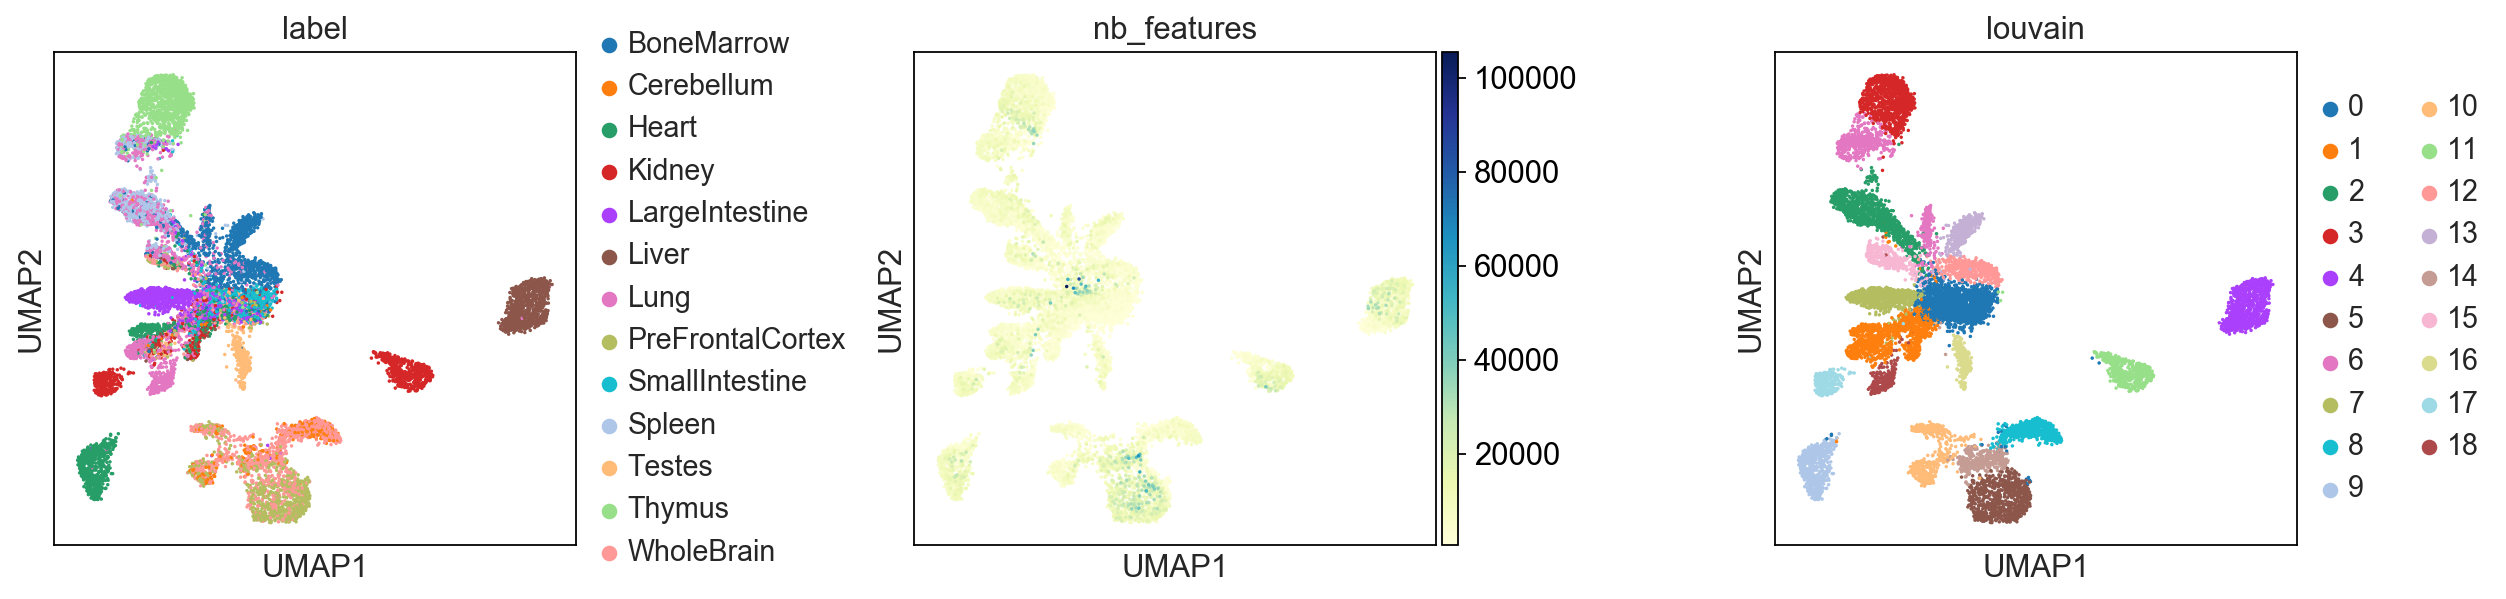

In [14]:
sc.pl.pca(adatareduced, color=['label', 'nb_features', 'louvain'], wspace=0.5)
sc.pl.tsne(adatareduced, color=['label', 'nb_features', 'louvain'], wspace=0.5)
sc.pl.umap(adatareduced, color=['label', 'nb_features', 'louvain'], wspace=0.5)

In [19]:
adatareduced.write('Cusanovich2018_subset_processed.h5ad')

ValueError: No member name (no member name)

In [20]:
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
import os
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score
import seaborn as sns

def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        print('step ' + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        
        print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    
    print('Cannot find the number of clusters')
    print('Clustering solution from last iteration is used:' + str(this_clusters) + ' at resolution ' + str(this_resolution))
    
    
# specify the directory where data are stored
DATADIR = ''

# specify the directory where data and metadata are stored
METADATADIR = '../../input/'

In [21]:
# metrics on the default louvain clustering

labels_true = adatareduced.obs['label']
labels_pred = adatareduced.obs['louvain']
print(adjusted_rand_score(labels_true, labels_pred))

0.3787932064510516


step 0
got 22 at resolution 1.5
step 1
got 17 at resolution 0.75
step 2
got 14 at resolution 0.375
step 3
got 11 at resolution 0.1875
step 4
got 12 at resolution 0.28125
step 5
got 14 at resolution 0.328125
step 6
got 14 at resolution 0.3046875
step 7
got 14 at resolution 0.29296875
step 8
got 14 at resolution 0.287109375
step 9
got 12 at resolution 0.2841796875
step 10
got 13 at resolution 0.28564453125


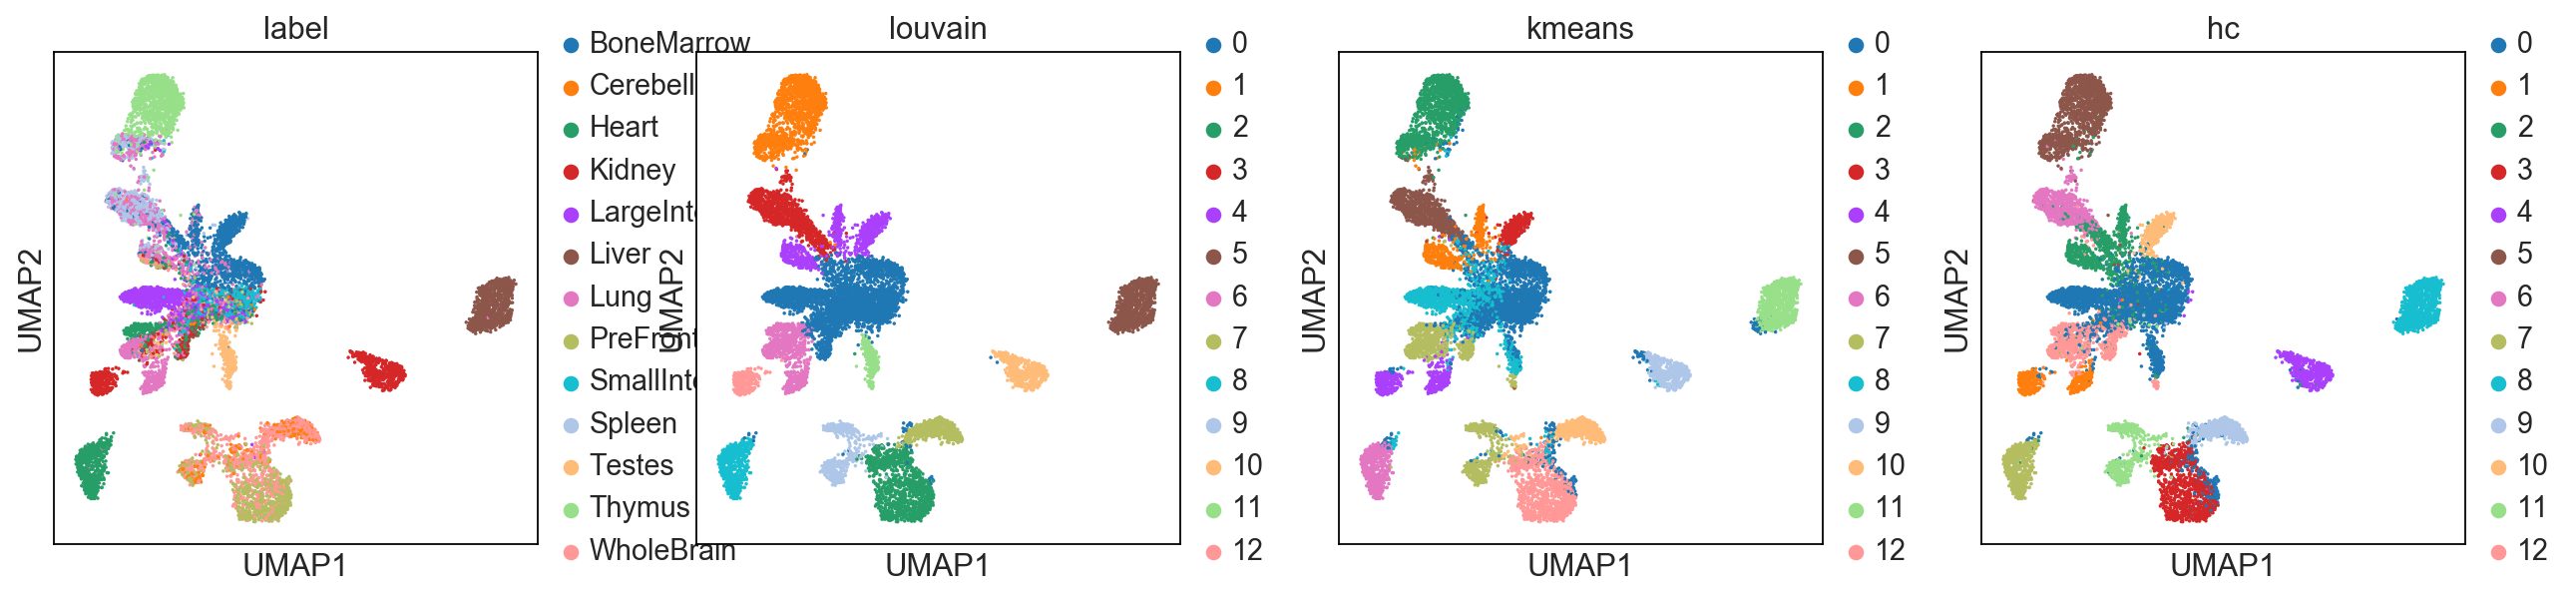

In [22]:
############ Benchmarking ############
    
df_metrics = pd.DataFrame(columns=['ARI_Louvain','ARI_kmeans','ARI_HC',
                                   'AMI_Louvain','AMI_kmeans','AMI_HC',
                                   'Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC'])


# set method name
method = 'epiScanpy-adata'

# convert the cell label to standard label
#adata.obs['label'] = adata.obs['cell_type']

# set the number of cluster for louvain
num_clusters = len(np.unique(adatareduced.obs['label']))
#print(num_clusters)

# set the epiScanpy metric raw in the pandas dataframe
df_metrics.loc[method,] = ""

## get the clusters

#Louvain
#sc.pp.neighbors(adata, n_neighbors=15,use_rep='X') # I MUST NOT recalculate the neighboring graph like this
#sc.tl.louvain(adata)
getNClusters(adatareduced,n_cluster=num_clusters)

#kmeans
#kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adatareduced.X)
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['kmeans'] = pd.Series(kmeans.labels_,index=adatareduced.obs.index).astype('category')

#hierachical clustering
#hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['hc'] = pd.Series(hc.labels_,index=adata.obs.index).astype('category')

#adjusted rank index
ari_louvain = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['louvain'])
ari_kmeans = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['kmeans'])
ari_hc = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['hc'])
#adjusted mutual information
ami_louvain = adjusted_mutual_info_score(adatareduced.obs['label'], adatareduced.obs['louvain'],average_method='arithmetic')
ami_kmeans = adjusted_mutual_info_score(adatareduced.obs['label'], adatareduced.obs['kmeans'],average_method='arithmetic')   
ami_hc = adjusted_mutual_info_score(adatareduced.obs['label'], adatareduced.obs['hc'],average_method='arithmetic')
#homogeneity
homo_louvain = homogeneity_score(adatareduced.obs['label'], adatareduced.obs['louvain'])
homo_kmeans = homogeneity_score(adatareduced.obs['label'], adatareduced.obs['kmeans'])
homo_hc = homogeneity_score(adatareduced.obs['label'], adatareduced.obs['hc'])

df_metrics.loc[method,['ARI_Louvain','ARI_kmeans','ARI_HC']] = [ari_louvain,ari_kmeans,ari_hc]
df_metrics.loc[method,['AMI_Louvain','AMI_kmeans','AMI_HC']] = [ami_louvain,ami_kmeans,ami_hc]
df_metrics.loc[method,['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = [homo_louvain,homo_kmeans,homo_hc] 
#adata.obs[['louvain','kmeans','hc']].to_csv(os.path.join(path_clusters ,method + '_clusters.tsv'),sep='\t')

sc.pl.umap(adatareduced, color=['label', 'louvain', 'kmeans', 'hc'])



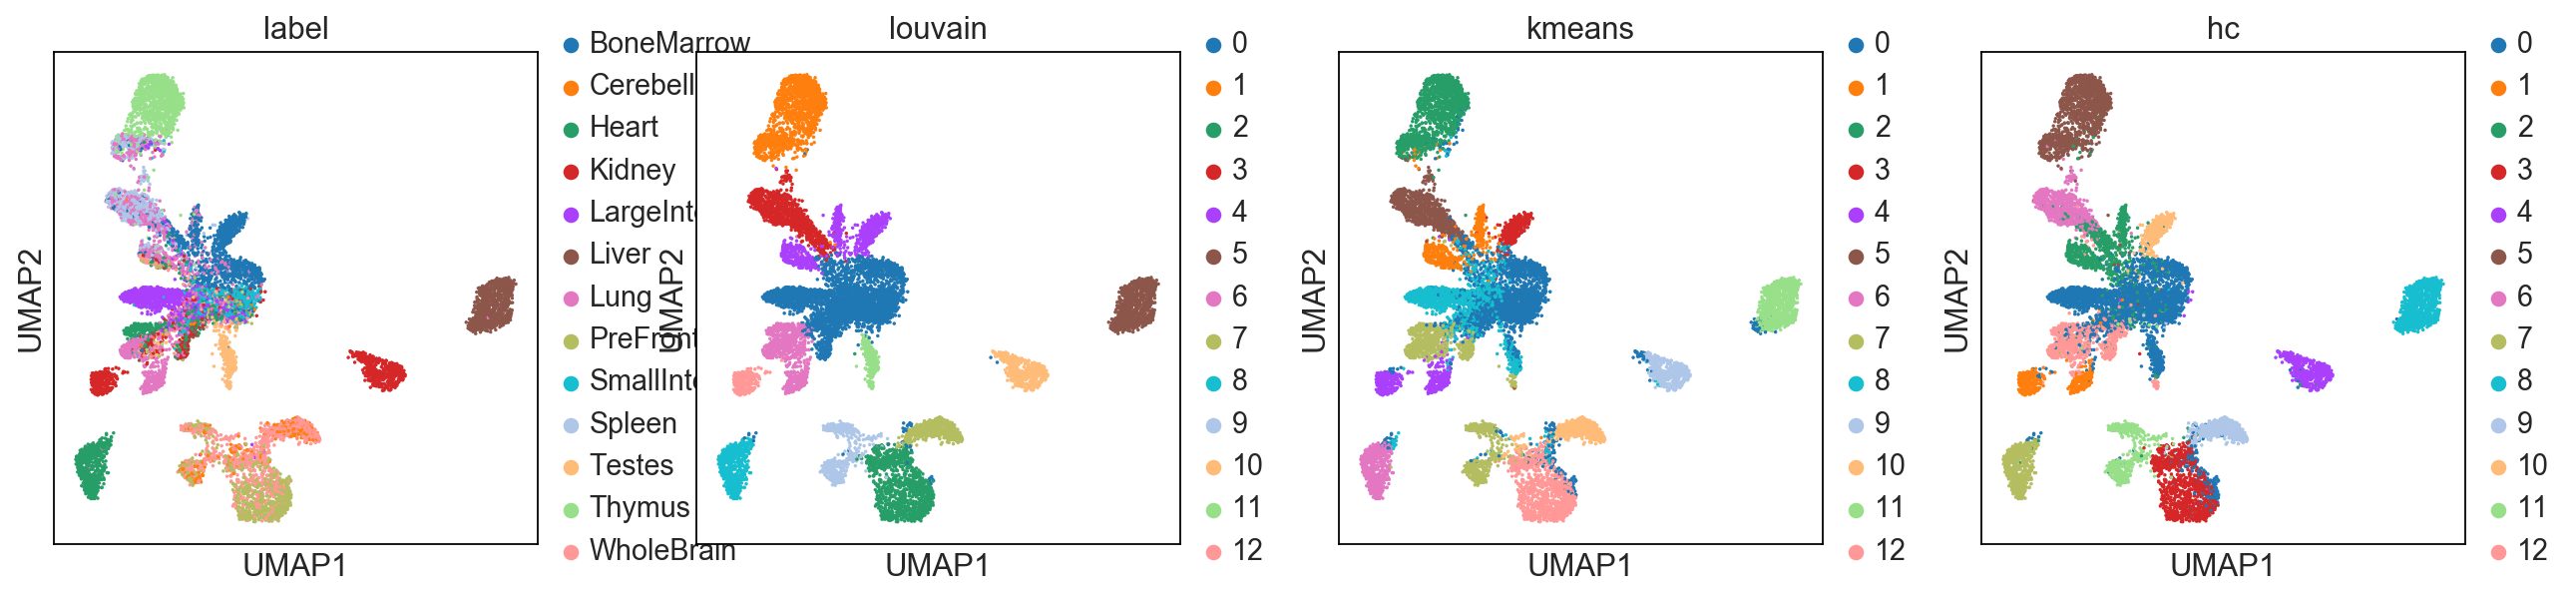

ARI_Louvain  ARI_kmeans    ARI_HC  AMI_Louvain  \
epiScanpy-adata         0.323795    0.297772  0.298068     0.573066   
ChromVAR_kmers          0.362156    0.318281  0.322602     0.547156   
ChromVAR_motifs         0.273587    0.234159  0.232830     0.467077   
cisTopic                0.326831    0.311433  0.334379     0.594191   
SnapATAC                0.311580    0.315666  0.238986     0.583190   
SCRAT_motifs            0.150932    0.077564  0.076397     0.299833   
BROCKMAN                0.229773    0.108314  0.095058     0.402846   
Cusanovich2018          0.314571    0.312622  0.394549     0.588781   
Control                 0.332837    0.031021  0.032305     0.548613   
GeneScoring             0.074074    0.018880  0.030184     0.159352   
Scasat                  0.358806    0.107472  0.121207     0.554397   
scABC                   0.033142    0.016431  0.030400     0.059114   
Cicero                  0.009463    0.005077  0.003377     0.033295   
ChromVAR_kmers_pca      0.393402    0.353105  0.330552     0.577130   
ChromVAR_motifs_pca     0.252594    0.237495  0.222042     0.475341   
GeneScoring_pca         0.184099    0.026525  0.029581     0.384399   
Cicero_pca              0.067577    0.005160  0.007204     0.133417   

                     AMI_kmeans    AMI_HC  Homogeneity_Louvain  \
epiScanpy-adata        0.508527  0.537719             0.552232   
ChromVAR_kmers         0.508931  0.505412             0.529241   
ChromVAR_motifs        0.381515  0.389418             0.452938   
cisTopic               0.548624  0.584576             0.562274   
SnapATAC               0.538058  0.570649             0.549473   
SCRAT_motifs           0.175588  0.174113             0.301070   
BROCKMAN               0.245153  0.216923             0.403183   
Cusanovich2018         0.532839  0.579267             0.562294   
Control                0.176790  0.183920             0.540980   
GeneScoring            0.115906  0.178871             0.151916   
Scasat                 0.339320  0.343008             0.552355   
scABC                  0.107217  0.191117             0.056010   
Cicero                 0.023408  0.021024             0.031283   
ChromVAR_kmers_pca     0.537296  0.523283             0.570369   
ChromVAR_motifs_pca    0.383546  0.387681             0.449016   
GeneScoring_pca        0.143917  0.159450             0.381420   
Cicero_pca             0.023527  0.025529             0.129841   

                     Homogeneity_kmeans  Homogeneity_HC               method  
epiScanpy-adata                0.500004        0.521658      epiScanpy-adata  
ChromVAR_kmers                 0.494062        0.499065       ChromVAR_kmers  
ChromVAR_motifs                0.378984        0.374202      ChromVAR_motifs  
cisTopic                       0.528385        0.572242             cisTopic  
SnapATAC                       0.526652        0.526307             SnapATAC  
SCRAT_motifs                   0.177310        0.174480         SCRAT_motifs  
BROCKMAN                       0.246948        0.218872             BROCKMAN  
Cusanovich2018                 0.520058        0.575403       Cusanovich2018  
Control                        0.145575        0.146171              Control  
GeneScoring                    0.095670        0.143932          GeneScoring  
Scasat                         0.321810        0.327857               Scasat  
scABC                          0.079421        0.156440                scABC  
Cicero                         0.019165        0.016876               Cicero  
ChromVAR_kmers_pca             0.529479        0.519517   ChromVAR_kmers_pca  
ChromVAR_motifs_pca            0.380229        0.371064  ChromVAR_motifs_pca  
GeneScoring_pca                0.121941        0.132441      GeneScoring_pca  
Cicero_pca                     0.019290        0.021323           Cicero_pca

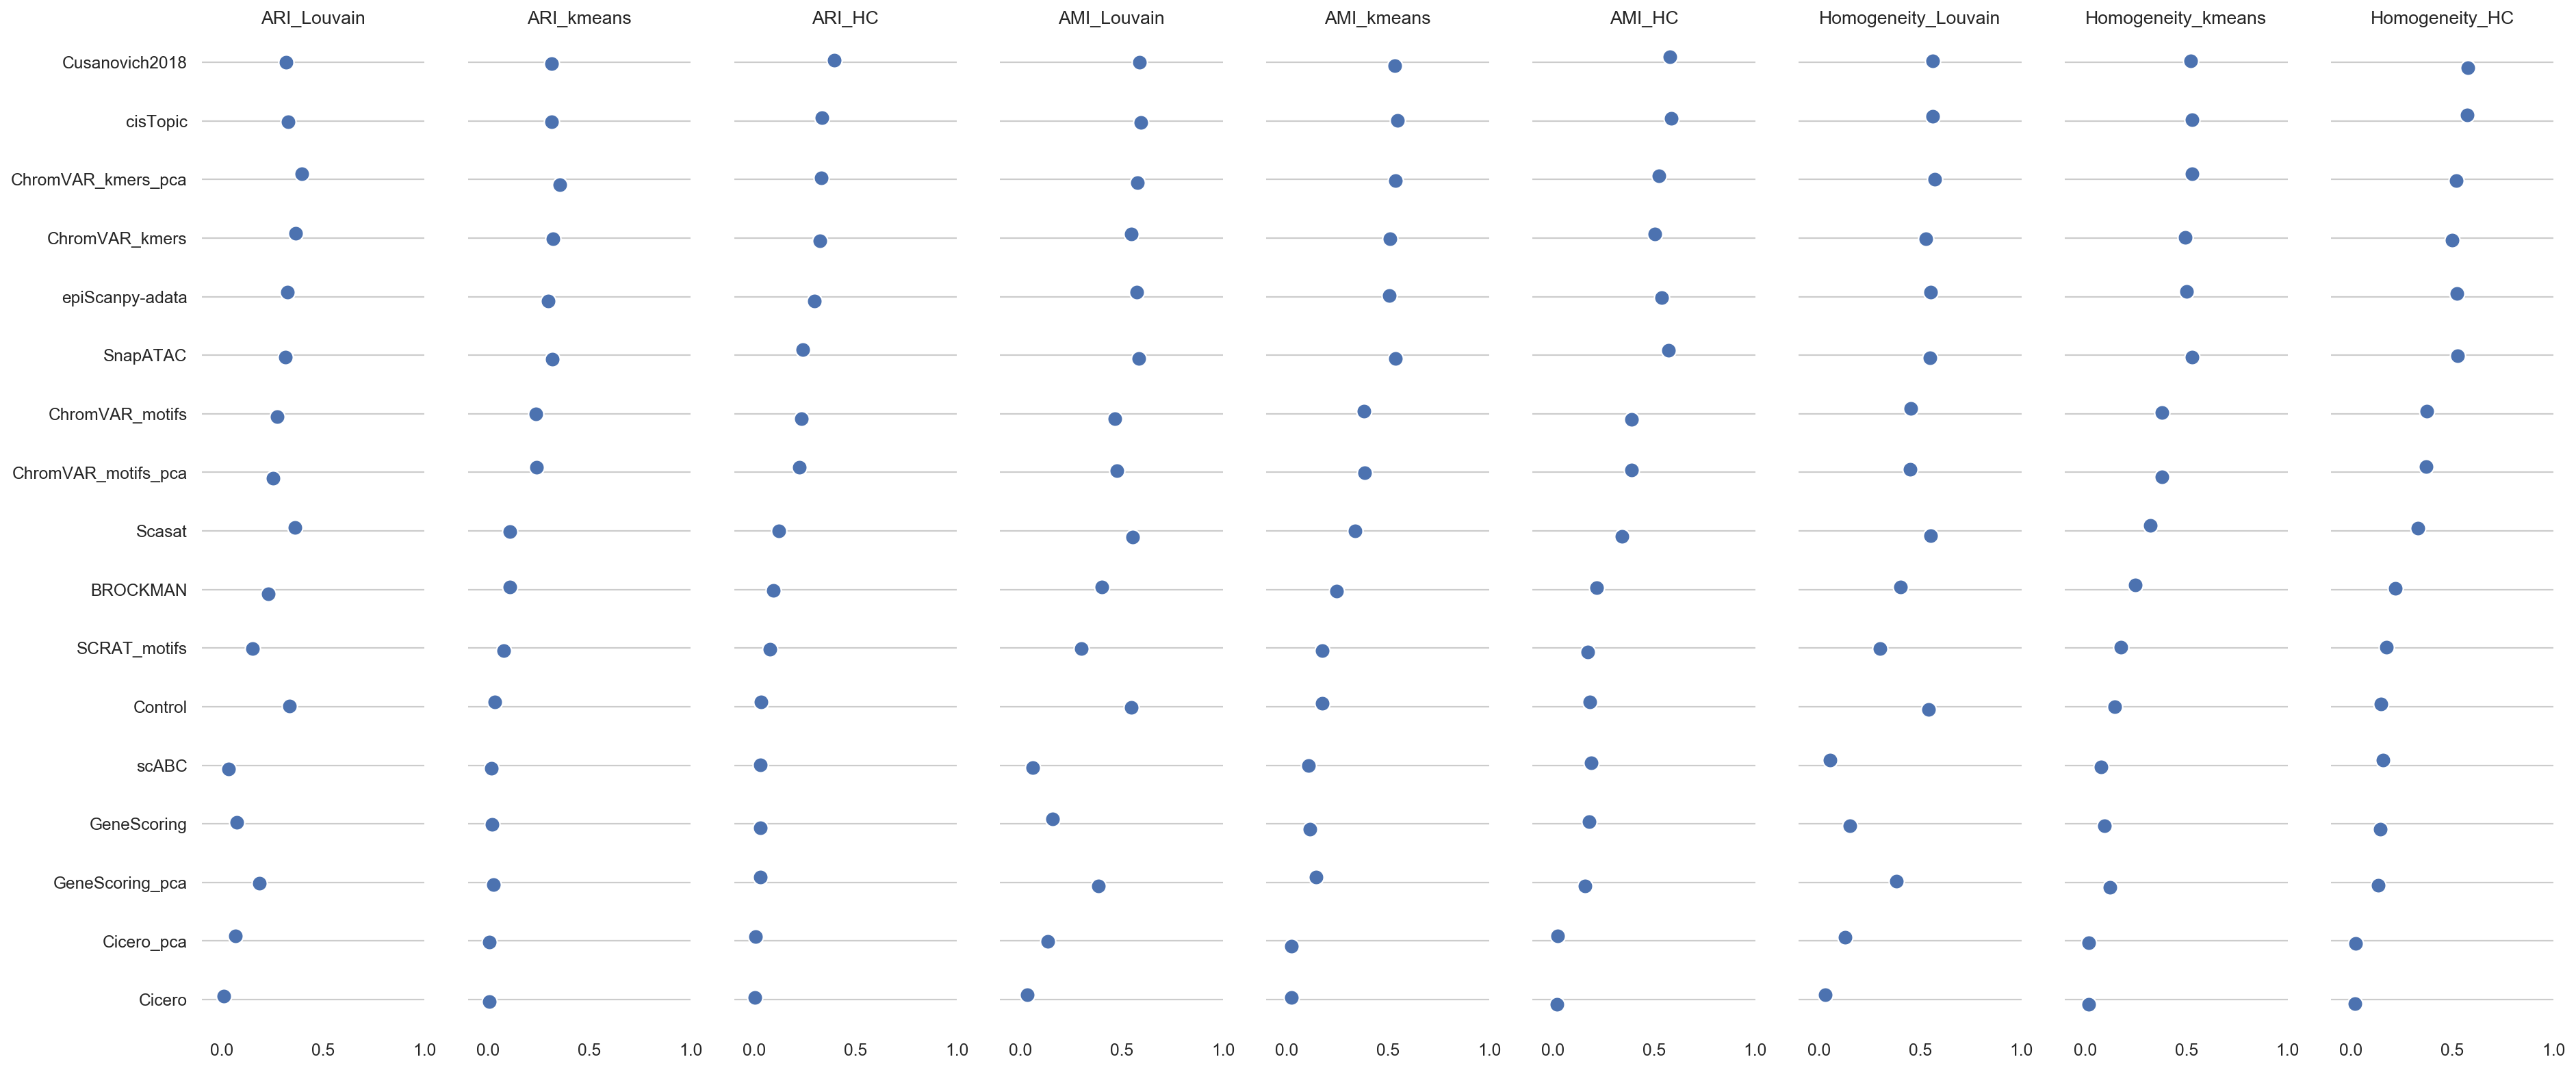

In [23]:
all_metrics = """ChromVAR_kmers	0.362156	0.318281	0.322602	0.547156	0.508931	0.505412	0.529241	0.494062	0.499065
ChromVAR_motifs	0.273587	0.234159	0.23283	0.467077	0.381515	0.389418	0.452938	0.378984	0.374202
cisTopic	0.326831	0.311433	0.334379	0.594191	0.548624	0.584576	0.562274	0.528385	0.572242
SnapATAC	0.31158	0.315666	0.238986	0.58319	0.538058	0.570649	0.549473	0.526652	0.526307
SCRAT_motifs	0.150932	0.077564	0.076397	0.299833	0.175588	0.174113	0.30107	0.17731	0.17448
BROCKMAN	0.229773	0.108314	0.0950577	0.402846	0.245153	0.216923	0.403183	0.246948	0.218872
Cusanovich2018	0.314571	0.312622	0.394549	0.588781	0.532839	0.579267	0.562294	0.520058	0.575403
Control	0.332837	0.0310206	0.0323049	0.548613	0.17679	0.18392	0.54098	0.145575	0.146171
GeneScoring	0.0740742	0.01888	0.0301842	0.159352	0.115906	0.178871	0.151916	0.0956696	0.143932
Scasat	0.358806	0.107472	0.121207	0.554397	0.33932	0.343008	0.552355	0.32181	0.327857
scABC	0.0331424	0.0164305	0.0304001	0.059114	0.107217	0.191117	0.0560104	0.0794209	0.15644
Cicero	0.00946335	0.00507737	0.00337704	0.0332948	0.0234078	0.0210244	0.0312832	0.0191649	0.0168756
ChromVAR_kmers_pca	0.393402	0.353105	0.330552	0.57713	0.537296	0.523283	0.570369	0.529479	0.519517
ChromVAR_motifs_pca	0.252594	0.237495	0.222042	0.475341	0.383546	0.387681	0.449016	0.380229	0.371064
GeneScoring_pca	0.184099	0.0265249	0.0295811	0.384399	0.143917	0.15945	0.38142	0.121941	0.132441
Cicero_pca	0.0675771	0.00516015	0.00720392	0.133417	0.0235267	0.025529	0.129841	0.0192896	0.0213231
SCRAT_pca	0.153423	0.0777187	0.0852386	0.286294	0.176089	0.181604	0.289815	0.177849	0.183358"""



all_metrics = [line.split('\t') for line in  all_metrics.split('\n')[:-1]]

for line in all_metrics:
    df_metrics.loc[line[0],['ARI_Louvain','ARI_kmeans','ARI_HC']] = line[1:4]
    df_metrics.loc[line[0],['AMI_Louvain','AMI_kmeans','AMI_HC']] = line[4:7]
    df_metrics.loc[line[0],['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = line[7:]

sc.pl.umap(adatareduced, color=['label', 'louvain', 'kmeans', 'hc'])


for key in df_metrics.keys():
    df_metrics[key] = [float(key) for key in df_metrics[key]]
    
df_metrics['method'] = df_metrics.index.tolist()


sns.set(style="whitegrid")

# data to plot
df_metrics

# Make the PairGrid
g = sns.PairGrid(df_metrics.sort_values("ARI_HC",
                                        ascending=False),
                 x_vars=df_metrics.columns[:9], y_vars=["method"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      #palette="ch:s=1,r=-.1,h=1_r",
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.1, 1.), xlabel="", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['ARI_Louvain', 'ARI_kmeans', 'ARI_HC',
          'AMI_Louvain', 'AMI_kmeans', 'AMI_HC',
          'Homogeneity_Louvain', 'Homogeneity_kmeans', 'Homogeneity_HC']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

df_metrics

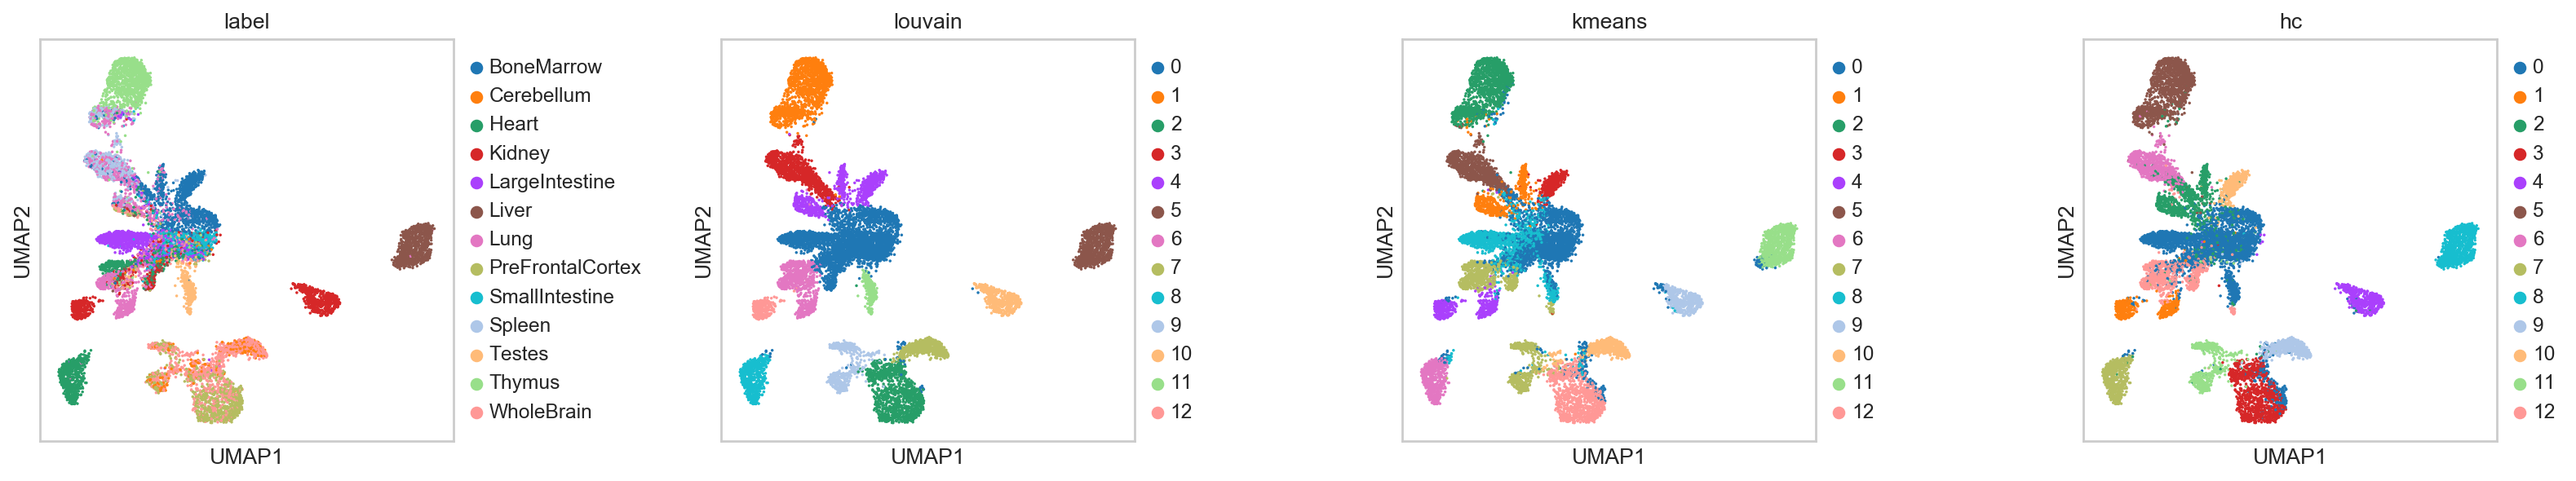

In [24]:
sc.pl.umap(adatareduced, color=['label', 'louvain', 'kmeans', 'hc'], wspace=0.5)